
Tổng quan nhãn churn:
churn
0    1271593
1    1215607
Name: count, dtype: int64

Tỷ lệ churn: 0.4887451752975233


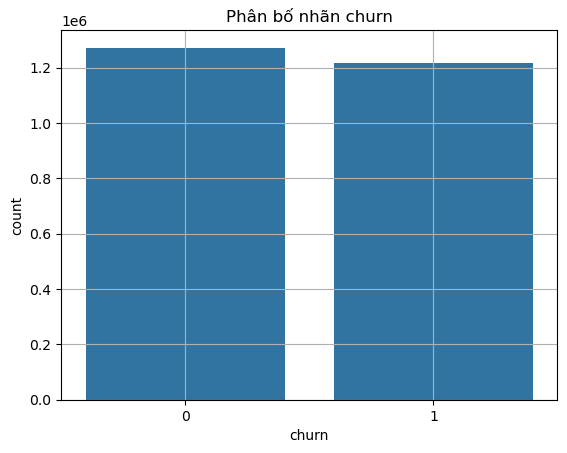

In [ ]:
# 📘 Notebook: Dự báo Tỷ lệ Khách hàng Rời bỏ (Churn Rate) bằng Transformer

# --- 1. Thư viện cần thiết ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add, TimeDistributed, GlobalAveragePooling1D
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# --- 2. Đọc dữ liệu và phân tích nhãn churn ---
df = pd.read_csv(r"C:\Users\nguye\CODE\TimeSeries\BTL\Thang10_Thang11\User\2019_Data_Cleaned.csv", parse_dates=['event_time'])
df['date'] = df['event_time'].dt.date

churn_counts = df['churn'].value_counts()
print("\nTổng quan nhãn churn:")
print(churn_counts)
print("\nTỷ lệ churn:", churn_counts[1] / churn_counts.sum())

sns.countplot(x='churn', data=df)
plt.title("Phân bố nhãn churn")
plt.grid(True)
plt.show()

In [2]:
# --- 3. Tính churn_rate theo ngày ---
df['date'] = pd.to_datetime(df['date'])
daily_stats = df.groupby('date').agg(
    total_users=('user_id', 'nunique'),
    churned_users=('churn', 'sum')
).reset_index()
daily_stats['churn_rate'] = daily_stats['churned_users'] / daily_stats['total_users']
daily_stats = daily_stats[daily_stats['total_users'] >= 10]

# --- 4. Chuẩn hóa và tạo dữ liệu chuỗi ---
scaler = MinMaxScaler()
daily_stats = daily_stats.set_index('date').asfreq('D').fillna(method='ffill')
churn_series = daily_stats[['churn_rate']]
scaled_churn = scaler.fit_transform(churn_series)

sequence_length = 30
X, y = [], []
for i in range(len(scaled_churn) - sequence_length):
    X.append(scaled_churn[i:i+sequence_length])
    y.append(scaled_churn[i+sequence_length])
X, y = np.array(X), np.array(y)

train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [3]:
df.shape

(2487200, 11)

In [4]:
# --- 5. Định nghĩa Transformer đơn giản ---
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)
    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Add()([x_ff, x])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

input_shape = X_train.shape[1:]
inputs = Input(shape=input_shape)
x = transformer_encoder(inputs, head_size=64, num_heads=2, ff_dim=64, dropout=0.1)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(16, activation="relu")(x)
outputs = Dense(1)(x)
model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1)     │        897 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 1)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 1)     │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 64)    │        128 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30, 1)     │         65 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 1)     │          0 │ dense_1[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1)         │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1)         │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │         32 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         17 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,143 (4.46 KB)

 Trainable params: 1,143 (4.46 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# --- 6. Huấn luyện ---
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=0)

# --- 7. Dự báo và đánh giá ---
pred_transformer = model.predict(X_test).flatten()
pred_transformer_inv = scaler.inverse_transform(pred_transformer.reshape(-1,1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

mae = mean_absolute_error(y_test_inv, pred_transformer_inv)
rmse = sqrt(mean_squared_error(y_test_inv, pred_transformer_inv))
mape = np.mean(np.abs((y_test_inv - pred_transformer_inv) / y_test_inv)) * 100

print("\nTransformer:")
print(f"MAE: {mae:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step

Transformer:
MAE: 2.57622
RMSE: 3.45810
MAPE: 21.47%


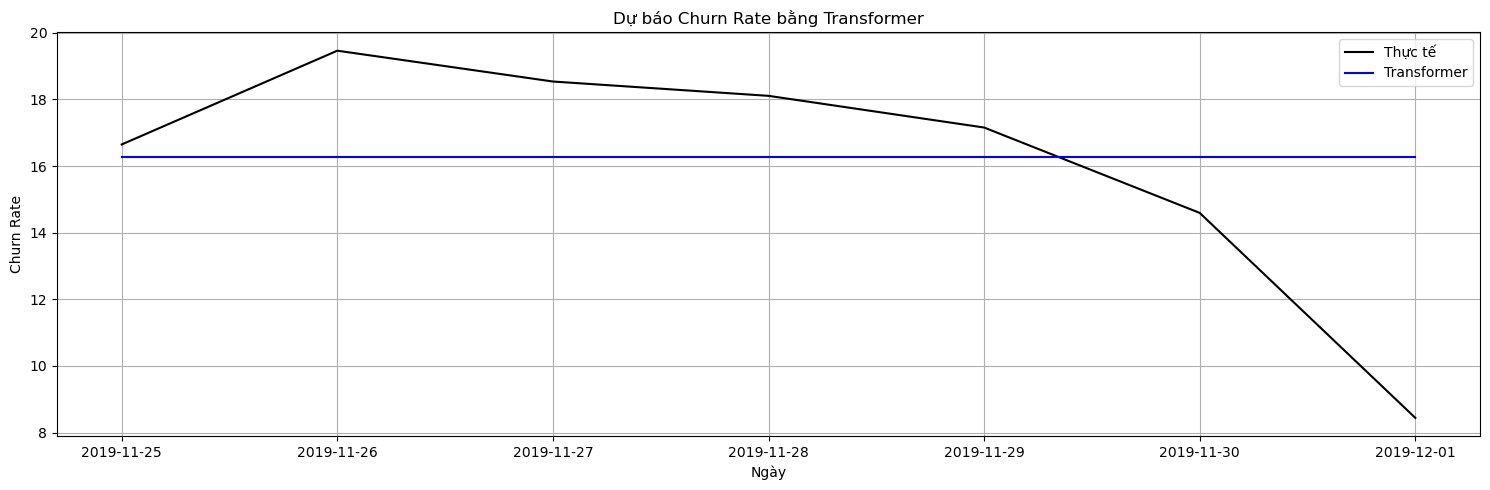

In [6]:
# --- 8. Trực quan hóa ---
plt.figure(figsize=(15,5))
plt.plot(daily_stats.index[-len(y_test_inv):], y_test_inv, label="Thực tế", color='black')
plt.plot(daily_stats.index[-len(pred_transformer_inv):], pred_transformer_inv, label="Transformer", color='blue')
plt.title("Dự báo Churn Rate bằng Transformer")
plt.xlabel("Ngày")
plt.ylabel("Churn Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()